# Deep Learning - Projeto Integrado

## Enunciado

A QuantumFinance está desejando construir um fundo de ações baseado em modelos de Deep Learning. A ideia é desenvolver um modelo que tenha como saída a compra ou venda de um determinada ação baseado na movimentação do mercado nos últimos 15 dias.<br>

Inicialmente 4 ações foram selecionadas para análise:<br>

- VALE3 – Vale do Rio Doce
- PETR4 – Petrobras
- BBAS3 – Banco do Brasil
- CSNA3 - Companhia Siderúrgica Nacional<br>

A empresa deseja um modelo de Deep Learning que seja um ‘perseguidor de
tendencia’, ou seja, se o papel sobe o modelo deve comprar, se o papel desce o
modelo deve vender.

Para isso a QuantumFinance contratou economistas que fizerem a rotulagem
dos dados baseado no valor de fechamento dos ativos. Inicialmente foi feita
uma suavização dos preços de fechamento, e por se tratar de um assunto
sigiloso, não foi informada a técnica de suavização utilizada. O próximo passo
foi realizar a rotulagem dia a dia, para verificar qual devemos comprar e qual
devemos vender

## Integrantes


    1) Nome: Jéssica Portela de Castro    RM: 359735
    2) Nome: Tiago Freire Barbosa         RM: 358404

## Importação das Bibliotecas

In [ ]:
!pip install visualkeras --quiet
!pip install pyts --quiet

import visualkeras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, BatchNormalization, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler

from keras.utils import plot_model

from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_features

from pyts.image import GramianAngularField
from PIL import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.4 MB/s eta 0:00:00


## Conjunto de Dados

### Dicionário de Variáveis

| **Variável**              | **Descrição**                                                       | **Categorias/Exemplos**     | **Tipo de Variável**        |
|---------------------------|----------------------------------------------------------------------|------------------------------|-----------------------------|
| Date                    | Data de referência da cotação                                       | Ex: 2000-01-24               | Qualitativa Ordinal         |
| Close                   | Preço de fechamento do ativo no dia                                | Ex: 1.062769                 | Quantitativa Contínua       |
| Smoothed_Close          | Preço de fechamento suavizado                                      | Ex: 1.071645                 | Quantitativa Contínua       |
| Label                   | Rótulo de classificação para aprendizado supervisionado            | Ex: -1, 1                 | Qualitativa Ordinal         |
| Past_X_Days_Close       | Preço de fechamento nos dias anteriores (1 a 15 dias)               | Ex: 1.088979                 | Quantitativa Contínua       |

## Importação do Dataset

Os arquivos em csv, foram armazenados em um repositório público do grupo no github, na importação com pandas utilizados a url do arquivo raw

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#BBAS3 – Banco do Brasil
df_treino_bbas3 = pd.read_csv('https://github.com/tiagofrbarbosa/datasets_fiap_dc_ia_9dtsr/raw/refs/heads/master/Deep%20Learning/BBAS3.SA/treino.csv')
df_teste_bbas3 = pd.read_csv('https://github.com/tiagofrbarbosa/datasets_fiap_dc_ia_9dtsr/raw/refs/heads/master/Deep%20Learning/BBAS3.SA/teste.csv')


#CSNA3 - Companhia Siderúrgica Nacional
df_treino_csna3 = pd.read_csv('https://github.com/tiagofrbarbosa/datasets_fiap_dc_ia_9dtsr/raw/refs/heads/master/Deep%20Learning/CSNA3.SA/treino.csv')
df_teste_csna3 = pd.read_csv('https://github.com/tiagofrbarbosa/datasets_fiap_dc_ia_9dtsr/raw/refs/heads/master/Deep%20Learning/CSNA3.SA/teste.csv')


#PETR4 – Petrobras
df_treino_petr4 = pd.read_csv('https://github.com/tiagofrbarbosa/datasets_fiap_dc_ia_9dtsr/raw/refs/heads/master/Deep%20Learning/PETR4.SA/treino.csv')
df_teste_petr4 = pd.read_csv('https://github.com/tiagofrbarbosa/datasets_fiap_dc_ia_9dtsr/raw/refs/heads/master/Deep%20Learning/PETR4.SA/teste.csv')


#VALE3 – Vale do Rio Doce
df_treino_vale3 = pd.read_csv('https://github.com/tiagofrbarbosa/datasets_fiap_dc_ia_9dtsr/raw/refs/heads/master/Deep%20Learning/VALE3.SA/treino.csv')
df_teste_vale3 = pd.read_csv('https://github.com/tiagofrbarbosa/datasets_fiap_dc_ia_9dtsr/raw/refs/heads/master/Deep%20Learning/VALE3.SA/teste.csv')

### Explorando os Datasets

#### Dicionário de Dataframes

Criando um dicionário com todos os dataframes para facilitar a análise em conjunto

In [ ]:
datasets = {"df_treino_bbas3":df_treino_bbas3,
            "df_teste_bbas3":df_teste_bbas3,
            "df_treino_csna3":df_treino_csna3,
            "df_teste_csna3":df_teste_csna3,
            "df_treino_petr4":df_treino_petr4,
            "df_teste_petr4":df_teste_petr4,
            "df_treino_vale3":df_treino_vale3,
            "df_teste_vale3":df_teste_vale3
            }

#### Valores Nulos

Nenhum dos datasets possui valores nulos

In [ ]:
for nome, df in datasets.items():
  total_nulos = df.isnull().sum().sum()
  print(f"{nome} : {total_nulos} valores nulos")

df_treino_bbas3 : 0 valores nulos
df_teste_bbas3 : 0 valores nulos
df_treino_csna3 : 0 valores nulos
df_teste_csna3 : 0 valores nulos
df_treino_petr4 : 0 valores nulos
df_teste_petr4 : 0 valores nulos
df_treino_vale3 : 0 valores nulos
df_teste_vale3 : 0 valores nulos


#### Estrutura dos Dados

Todos os datasets possuem os mesmos formatos de campo, para valores relativos a fechamentos predominam o **float64**, os campos de data estão como **object** e o label como **int64**

In [ ]:
df_treino_bbas3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4735 entries, 0 to 4734
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          4735 non-null   int64  
 1   Date                4735 non-null   object 
 2   Close               4735 non-null   float64
 3   Smoothed_Close      4735 non-null   float64
 4   Label               4735 non-null   int64  
 5   Past_1_Days_Close   4735 non-null   float64
 6   Past_2_Days_Close   4735 non-null   float64
 7   Past_3_Days_Close   4735 non-null   float64
 8   Past_4_Days_Close   4735 non-null   float64
 9   Past_5_Days_Close   4735 non-null   float64
 10  Past_6_Days_Close   4735 non-null   float64
 11  Past_7_Days_Close   4735 non-null   float64
 12  Past_8_Days_Close   4735 non-null   float64
 13  Past_9_Days_Close   4735 non-null   float64
 14  Past_10_Days_Close  4735 non-null   float64
 15  Past_11_Days_Close  4735 non-null   float64
 16  Past_1

#### Resultados de target possíveis

Temos 2 tipos de target possíveis, sendo:

- **-1** - Representa queda, o modelo deve vender
- **1** - Representa subida, o modelo deve comprar

In [ ]:
df_treino_bbas3['Label'].unique()

array([-1,  1])

#### Dimensão dos Dados

Os dataframes possuem temanhos aproximados no conjuntos de treino e teste, os dataframes **PETR4** e **VALE3** possuem tamanhos exatos

In [ ]:
for nome, df in datasets.items():
  print(f"{nome}: {df.shape}")

df_treino_bbas3: (4735, 20)
df_teste_bbas3: (1185, 20)
df_treino_csna3: (4743, 20)
df_teste_csna3: (1186, 20)
df_treino_petr4: (4808, 20)
df_teste_petr4: (1203, 20)
df_treino_vale3: (4808, 20)
df_teste_vale3: (1203, 20)


#### Distribuição da Varável Target

Em todos os datasets o target **-1** possui maior números de amostras, o desbalanceamento está entre leve e moderado, dispensando aplicação de técnicas como SMOTE<br><br>

- df_treino_bbas3 → 55% vs 45% → Leve desbalanceamento
- df_teste_bbas3 → 58% vs 42% → Moderado desbalanceamento
- df_treino_csna3 → 56% vs 44% → Leve
- df_teste_csna3 → 58% vs 42% → Moderado
- df_treino_petr4 → 55% vs 45% → Leve
- df_teste_petr4 → 48% vs 52% → Quase balanceado
- df_treino_vale3 → 56% vs 44% → Leve
- df_teste_vale3 → 50% vs 50% → Totalmente balanceado

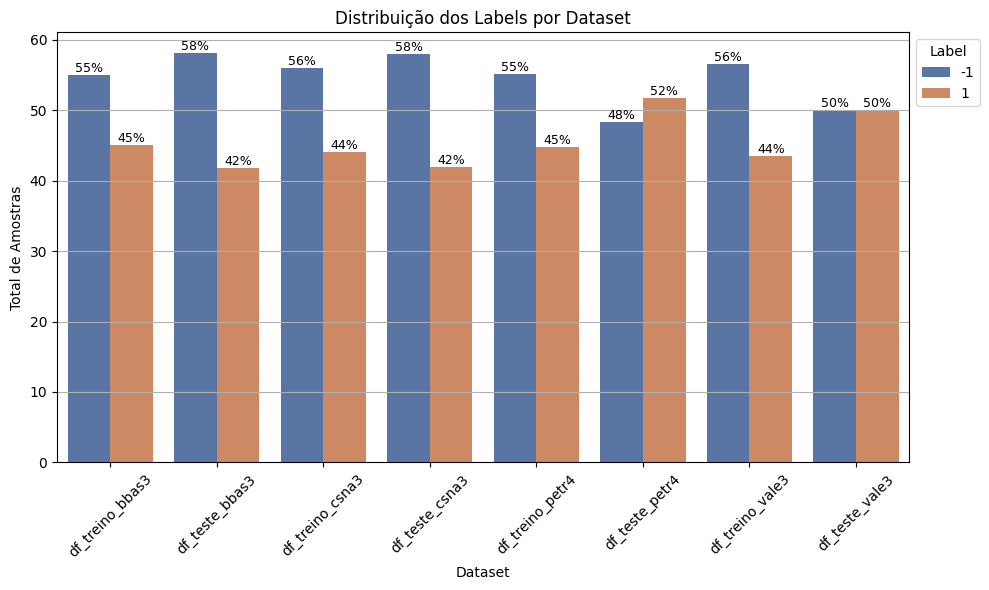

In [ ]:
distribuicao = []

for nome, df in datasets.items():
    contagem = df['Label'].value_counts()
    total = contagem.sum()
    for label, qtd in contagem.items():
        perc = (qtd / total) * 100
        distribuicao.append({
            'Dataset': nome,
            'Label': label,
            'Total': qtd,
            'Percentual': perc
        })

df_distribuicao = pd.DataFrame(distribuicao)

plt.figure(figsize=(10,6))
ax = sns.barplot(data=df_distribuicao, x='Dataset', y='Percentual', hue='Label', palette='deep')

plt.title('Distribuição dos Labels por Dataset')
plt.ylabel('Total de Amostras')
plt.xlabel('Dataset')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Label', loc='upper left', bbox_to_anchor=(1, 1))

for bars in ax.containers:
    for bar in bars:
        altura = bar.get_height()
        if altura > 0:
            x_pos = bar.get_x() + bar.get_width() / 2
            dataset = bar.get_x() + bar.get_width() / 2
            ax.text(x_pos, altura, f'{altura:.0f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

#### Visualizando linhas iniciais

In [ ]:
df_treino_bbas3.head(5)

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,1,2000-01-24,1.062769,1.071645,-1,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355,1.033940,1.023457,1.074564
1,2,2000-01-26,1.087668,1.073247,-1,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355,1.033940,1.023457
2,3,2000-01-27,1.064080,1.072330,-1,1.087668,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355,1.033940
3,4,2000-01-28,1.036561,1.068753,-1,1.064080,1.087668,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355
4,5,2000-01-31,1.035250,1.065403,-1,1.036561,1.064080,1.087668,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767


#Pré-Processamento

## Definindo Features e Target

Em nossos modelos utilizaremos as features referente aos últimos 15 dias, retirando as colunas de data e fechamento<br>

Retiramos as informações referente a fechamento para evitar vazamento de dados para o modelo<br>

Quanto a data ela não está em um formato númerico, não sendo possível a normalização, além disso no momento não iremos extrair informações referente a sazonalidade da série temporal

In [ ]:
features = [
    'Past_1_Days_Close',
    'Past_2_Days_Close',
    'Past_3_Days_Close',
    'Past_4_Days_Close',
    'Past_5_Days_Close',
    'Past_6_Days_Close',
    'Past_7_Days_Close',
    'Past_8_Days_Close',
    'Past_9_Days_Close',
    'Past_10_Days_Close',
    'Past_11_Days_Close',
    'Past_12_Days_Close',
    'Past_13_Days_Close',
    'Past_14_Days_Close',
    'Past_15_Days_Close'
            ]

target = ['Label']

## Binarização do Target

Convertemos a label de **-1** para **0** e mantemos o **1**, desta forma conseguiremos utilizar a função de ativação **sigmoid**, durante testes de configuração percebemos um desempenho superior em relação a **tanh**

In [ ]:
df_treino_bbas3['Label'] = df_treino_bbas3['Label'].replace({-1: 0, 1: 1})
df_teste_bbas3['Label'] = df_teste_bbas3['Label'].replace({-1: 0, 1: 1})

df_treino_csna3['Label'] = df_treino_csna3['Label'].replace({-1: 0, 1: 1})
df_teste_csna3['Label'] = df_teste_csna3['Label'].replace({-1: 0, 1: 1})

df_treino_petr4['Label'] = df_treino_petr4['Label'].replace({-1: 0, 1: 1})
df_teste_petr4['Label'] = df_teste_petr4['Label'].replace({-1: 0, 1: 1})

df_treino_vale3['Label'] = df_treino_vale3['Label'].replace({-1: 0, 1: 1})
df_teste_vale3['Label'] = df_teste_vale3['Label'].replace({-1: 0, 1: 1})

## Criação das Variáveis X e y

 convertendo o dataFrames do pandas em arrays NumPy, que é o formato aceito pelas redes neurais do Keras/TensorFlow

In [ ]:
X_train_bbas3 = df_treino_bbas3[features].to_numpy()
y_train_bbas3 = df_treino_bbas3[target].to_numpy()

X_test_bbas3 = df_teste_bbas3[features].to_numpy()
y_test_bbas3 = df_teste_bbas3[target].to_numpy()

X_train_csna3 = df_treino_csna3[features].to_numpy()
y_train_csna3 = df_treino_csna3[target].to_numpy()

X_test_csna3 = df_teste_csna3[features].to_numpy()
y_test_csna3 = df_teste_csna3[target].to_numpy()

X_train_petr4 = df_treino_petr4[features].to_numpy()
y_train_petr4 = df_treino_petr4[target].to_numpy()

X_test_petr4 = df_teste_petr4[features].to_numpy()
y_test_petr4 = df_teste_petr4[target].to_numpy()

X_train_vale3 = df_treino_vale3[features].to_numpy()
y_train_vale3 = df_treino_vale3[target].to_numpy()

X_test_vale3 = df_teste_vale3[features].to_numpy()
y_test_vale3 = df_teste_vale3[target].to_numpy()

## Normalização e Reshape

Normalização dos dados com StandardScaler e reshape para alterar o formato do array para 3 dimensões:<br>

**(amostras, passos de tempo, 1 feature)**<br>

Este formato será passado como entrada para uma Conv1D, neste caso 15 dias de histórico, com 1 variável por dia<br>

O **-1** permite ao NumPy calcular automaticamente o número de amostras, baseado no tamanho total do array

In [ ]:
scaler = StandardScaler()

X_train_bbas3 = scaler.fit_transform(X_train_bbas3).reshape(-1,15,1)
X_test_bbas3 = scaler.transform(X_test_bbas3).reshape(-1,15,1)

X_train_csna3 = scaler.fit_transform(X_train_csna3).reshape(-1,15,1)
X_test_csna3 = scaler.transform(X_test_csna3).reshape(-1,15,1)

X_train_petr4 = scaler.fit_transform(X_train_petr4).reshape(-1,15,1)
X_test_petr4 = scaler.transform(X_test_petr4).reshape(-1,15,1)

X_train_vale3 = scaler.fit_transform(X_train_vale3).reshape(-1,15,1)
X_test_vale3 = scaler.transform(X_test_vale3).reshape(-1,15,1)

# Criação da Rede Neural

## CNN1D + LSTM Separadas por Ativo

Como proposta de resolução do problema tilizaremos uma CNN1D + LSTM, após testes constatamos que essa arquitetura possui melhores resultados em séries temporais como nosso dataset<br>

a CNN1D consegue captar padrões locais e variações curtas na sequência, enquanto a LSTM entende dependências de longo prazo e memória sequencial

### BBAS3

#### Ajuste de Class Weights

Especificamente no ativo BBAS3 realizamos o balanceamento de classes via cálculo de pesos, atribuindo maior importância à classe minoritária durante o treinamento, com o objetivo de mitigar o impacto do desbalanceamento nos resultados do modelo<br>

Após treinamento neste ativo, verificamos através das validações que a rede não consegue fazer predições para classe 1 sem o ajuste de class weights

In [ ]:
y_train_bin = y_train_bbas3.ravel()

classes = np.array([0, 1])

weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_bin)

class_weights_dict = {classes[0]: weights[0], classes[1]: weights[1]}

In [ ]:
print(weights)

[0.90987702 1.10993905]


Utilizamos a API Sequential do Tensorflow com a mesma arquitetura de camadas para treinar os 4 ativos, criamos uma rede neural para cada ativo, para evitar que treinemos o mesmo modelo com dados diferentes<br><br>

A arquitetura desenvolvida combina camadas convolucionais e recorrentes, sendo ideal para séries temporais financeiras:

- **Camadas Convolucionais 1D (Conv1D):**  
  Duas camadas com 128 filtros e kernel de tamanho 3, responsáveis por detectar padrões locais e variações curtas nos preços dos últimos 15 dias

- **Batch Normalization:**  
  Normaliza as ativações da camada anterior, acelerando o treinamento e contribuindo para a estabilidade do modelo

- **MaxPooling1D:**  
  Reduz a dimensionalidade da sequência, mantendo apenas as informações mais relevantes

- **Dropout:**  
  Aplicado após as camadas convolucionais e LSTM, previne overfitting ao desativar aleatoriamente parte das ativações durante o treinamento

- **LSTM (64 e 32 unidades):**  
  Capta dependências de longo prazo e relações temporais complexas, permitindo ao modelo considerar o histórico sequencial de forma eficiente

- **Camadas Dense:**  
  - Camada intermediária com 32 neurônios e ativação ReLU, responsável por refinar o aprendizado
  - Camada de saída com 1 neurônio e ativação Sigmoid, gerando uma probabilidade entre 0 e 1 para decisão de compra ou venda

- **EarlyStopping:**  
  Monitora a perda de validação e interrompe o treinamento caso não haja melhora após 10 épocas, evitando overfitting

- **Otimização:**  
  Utilizado o otimizador Adam com taxa de aprendizado reduzida (0.0003) para maior estabilidade, considerando a natureza sensível de séries temporais

- **Class Weights:**  
  Aplicado para balanceamento das classes, atribuindo maior peso à classe minoritária (compra ou venda), mitigando o impacto do desbalanceamento no aprendizado

In [ ]:
model_bbas3 = Sequential()

model_bbas3.add(Conv1D(128, 3, activation='relu', input_shape=(15,1), padding='same'))
model_bbas3.add(BatchNormalization())
model_bbas3.add(Conv1D(128, 3, activation='relu', padding='same'))
model_bbas3.add(MaxPooling1D(2))
model_bbas3.add(Dropout(0.3))

model_bbas3.add(LSTM(64,return_sequences=True))
model_bbas3.add(Dropout(0.3))
model_bbas3.add(LSTM(32))
model_bbas3.add(Dropout(0.3))

model_bbas3.add(Dense(32, activation='relu'))
model_bbas3.add(Dense(1, activation='sigmoid'))

early_stop_bbas3 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

optimizer_bbas3 = Adam(learning_rate=0.0003)

model_bbas3.compile(optimizer=optimizer_bbas3, loss='binary_crossentropy', metrics=['accuracy'])

history_bbas3 = model_bbas3.fit(X_train_bbas3,
                    y_train_bbas3,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stop_bbas3],
                    class_weight=class_weights_dict
                                )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 27s 75ms/step - accuracy: 0.5297 - loss: 0.6893 - val_accuracy: 0.5026 - val_loss: 0.6983
Epoch 2/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.5622 - loss: 0.6774 - val_accuracy: 0.6463 - val_loss: 0.6584
Epoch 3/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6192 - loss: 0.6163 - val_accuracy: 0.7445 - val_loss: 0.5380
Epoch 4/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.6919 - loss: 0.5414 - val_accuracy: 0.6727 - val_loss: 0.5997
Epoch 5/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7297 - loss: 0.4980 - val_accuracy: 0.7244 - val_loss: 0.5037
Epoch 6/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7081 - loss: 0.5240 - val_accuracy: 0.8046 - val_loss: 0.4438
Epoch 7/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7284 - loss: 0.5021 - val_accuracy: 0.8532 - val_loss: 0.3714
Epoch 8/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7438 - loss: 0.4687 -

#### Visualização da Arquitetura de Camadas

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


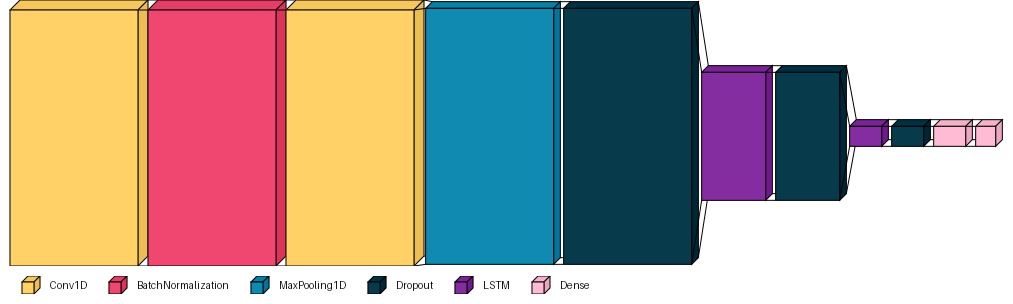

In [ ]:
visualkeras.layered_view(model_bbas3, scale_xy=2.0, scale_z=1.0, legend=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 15, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 15, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 7, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 339,141 (1.29 MB)

 Trainable params: 112,961 (441.25 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 225,924 (882.52 KB)

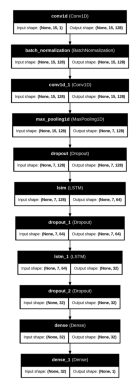

In [ ]:
model_bbas3.summary()

plot_model(model_bbas3, to_file='cnn-quantum-finance.png', show_shapes=True, show_layer_names=True)

img = Image.open('cnn-quantum-finance.png')
img = img.resize((int(img.width * 1.5), int(img.height * 1.5)))

plt.imshow(img)
plt.axis('off')
plt.show()

### CSNA3

In [ ]:
model_csna3 = Sequential()

model_csna3.add(Conv1D(128, 3, activation='relu', input_shape=(15,1), padding='same'))
model_csna3.add(BatchNormalization())
model_csna3.add(Conv1D(128, 3, activation='relu', padding='same'))
model_csna3.add(MaxPooling1D(2))
model_csna3.add(Dropout(0.3))

model_csna3.add(LSTM(64,return_sequences=True))
model_csna3.add(Dropout(0.3))
model_csna3.add(LSTM(32))
model_csna3.add(Dropout(0.3))

model_csna3.add(Dense(32, activation='relu'))
model_csna3.add(Dense(1, activation='sigmoid'))

early_stop_csna3 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

optimizer_csna3 = Adam(learning_rate=0.0003)

model_csna3.compile(optimizer=optimizer_csna3, loss='binary_crossentropy', metrics=['accuracy'])

history_csna3 = model_csna3.fit(X_train_csna3,
                    y_train_csna3,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stop_csna3])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.5408 - loss: 0.6905 - val_accuracy: 0.5943 - val_loss: 0.6870
Epoch 2/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5871 - loss: 0.6676 - val_accuracy: 0.6154 - val_loss: 0.6523
Epoch 3/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6853 - loss: 0.5801 - val_accuracy: 0.7977 - val_loss: 0.5055
Epoch 4/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7261 - loss: 0.5075 - val_accuracy: 0.8546 - val_loss: 0.3370
Epoch 5/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7438 - loss: 0.4821 - val_accuracy: 0.8609 - val_loss: 0.3256
Epoch 6/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7934 - loss: 0.4371 - val_accuracy: 0.8588 - val_loss: 0.3206
Epoch 7/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8001 - loss: 0.4056 - val_accuracy: 0.8599 - val_loss: 0.3028
Epoch 8/100
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7882 - loss: 0.4185 -

### PETR4

In [ ]:
model_petr4 = Sequential()

model_petr4.add(Conv1D(128, 3, activation='relu', input_shape=(15,1), padding='same'))
model_petr4.add(BatchNormalization())
model_petr4.add(Conv1D(128, 3, activation='relu', padding='same'))
model_petr4.add(MaxPooling1D(2))
model_petr4.add(Dropout(0.3))

model_petr4.add(LSTM(64,return_sequences=True))
model_petr4.add(Dropout(0.3))
model_petr4.add(LSTM(32))
model_petr4.add(Dropout(0.3))

model_petr4.add(Dense(32, activation='relu'))
model_petr4.add(Dense(1, activation='sigmoid'))

early_stop_petr4 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

optimizer_petr4 = Adam(learning_rate=0.0003)

model_petr4.compile(optimizer=optimizer_petr4, loss='binary_crossentropy', metrics=['accuracy'])

history_petr4 = model_petr4.fit(X_train_petr4,
                    y_train_petr4,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stop_petr4])

Epoch 1/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.5295 - loss: 0.6906 - val_accuracy: 0.6570 - val_loss: 0.6900
Epoch 2/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6124 - loss: 0.6478 - val_accuracy: 0.5832 - val_loss: 0.6786
Epoch 3/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.6784 - loss: 0.5666 - val_accuracy: 0.6830 - val_loss: 0.6118
Epoch 4/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7365 - loss: 0.4960 - val_accuracy: 0.7516 - val_loss: 0.5259
Epoch 5/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7578 - loss: 0.4744 - val_accuracy: 0.8503 - val_loss: 0.3669
Epoch 6/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7559 - loss: 0.4733 - val_accuracy: 0.7370 - val_loss: 0.4832
Epoch 7/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7686 - loss: 0.4461 - val_accuracy: 0.8857 - val_loss: 0.2855
Epoch 8/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7876 - loss: 0.4269 -

### VALE3

In [ ]:
model_vale3 = Sequential()

model_vale3.add(Conv1D(128, 3, activation='relu', input_shape=(15,1), padding='same'))
model_vale3.add(BatchNormalization())
model_vale3.add(Conv1D(128, 3, activation='relu', padding='same'))
model_vale3.add(MaxPooling1D(2))
model_vale3.add(Dropout(0.3))

model_vale3.add(LSTM(64,return_sequences=True))
model_vale3.add(Dropout(0.3))
model_vale3.add(LSTM(32))
model_vale3.add(Dropout(0.3))

model_vale3.add(Dense(32, activation='relu'))
model_vale3.add(Dense(1, activation='sigmoid'))

early_stop_vale3 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

optimizer_vale3 = Adam(learning_rate=0.0003)

model_vale3.compile(optimizer=optimizer_vale3, loss='binary_crossentropy', metrics=['accuracy'])

history_vale3 = model_vale3.fit(X_train_vale3,
                    y_train_vale3,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stop_vale3])

Epoch 1/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.5514 - loss: 0.6907 - val_accuracy: 0.5644 - val_loss: 0.6896
Epoch 2/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.5600 - loss: 0.6763 - val_accuracy: 0.5717 - val_loss: 0.6804
Epoch 3/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6023 - loss: 0.6471 - val_accuracy: 0.6279 - val_loss: 0.6287
Epoch 4/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6656 - loss: 0.5839 - val_accuracy: 0.7526 - val_loss: 0.4990
Epoch 5/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6908 - loss: 0.5430 - val_accuracy: 0.7682 - val_loss: 0.5206
Epoch 6/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.7347 - loss: 0.4835 - val_accuracy: 0.6778 - val_loss: 0.6896
Epoch 7/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7104 - loss: 0.5059 - val_accuracy: 0.8233 - val_loss: 0.3937
Epoch 8/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7434 - loss: 0.4746 -

## Evolução da Acurácia - Modelos por Ativo

Todos os modelos apresentam aumento inicial rápido de acurácia nas primeiras épocas<br>

Após estabilização, alguns ativos mostram sinais de overfitting, onde a acurácia de validação oscila ou cai enquanto a de treino segue aumentando

Modelos para ativos diferentes têm comportamentos levemente distintos, indicando que cada papel possui características específicas de dificuldade ou padrão

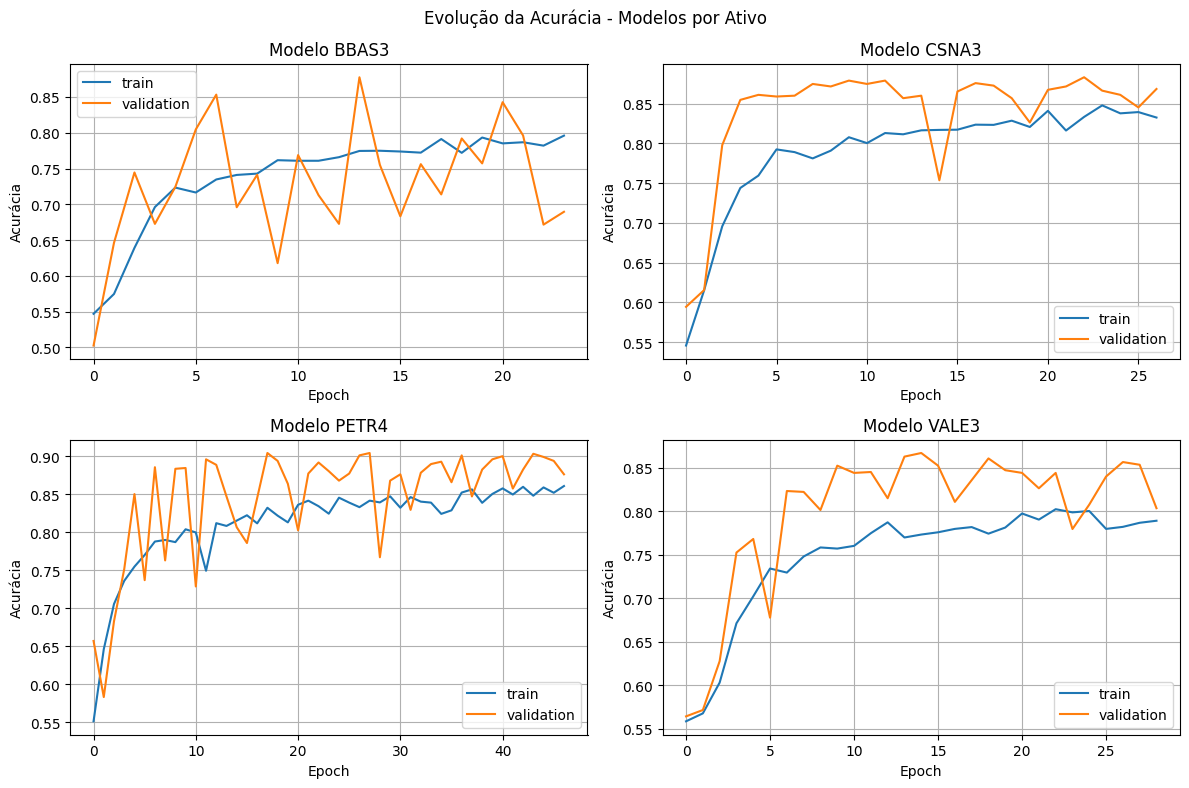

In [ ]:
historicos = {
    "BBAS3": history_bbas3,
    "CSNA3": history_csna3,
    "PETR4": history_petr4,
    "VALE3": history_vale3
}

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Evolução da Acurácia - Modelos por Ativo')

axs = axs.flatten()

for i, (nome, historico) in enumerate(historicos.items()):
    axs[i].plot(historico.history['accuracy'], label='train')
    axs[i].plot(historico.history['val_accuracy'], label='validation')
    axs[i].set_title(f'Modelo {nome}')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Acurácia')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

## Erro e Acurácia das Redes Neurais

Os resultados indicam que o modelo apresentou bom desempenho na tarefa de classificação binária<br>

Com acurácia variando entre aproximadamente 79% e 85% entre os diferentes ativos<br>

A menor taxa de erro foi observada em BBAS3 e VALE3, enquanto CSNA3 obteve o desempenho mais modesto

In [ ]:
print("======== BBAS3 ======== ")
scores_bbas3 = model_bbas3.evaluate(X_test_bbas3, y_test_bbas3, verbose=0)
print("Erro da CNN: %.2f%%" % (100-scores_bbas3[1]*100))
print("Acurária da CNN: %.2f%%" % (scores_bbas3[1]*100))
print('\n')

print("======== CSNA3 ======== ")
scores_csna3 = model_csna3.evaluate(X_test_csna3, y_test_csna3, verbose=0)
print("Erro da CNN: %.2f%%" % (100-scores_csna3[1]*100))
print("Acurária da CNN: %.2f%%" % (scores_csna3[1]*100))
print('\n')

print("======== PETR4 ======== ")
scores_petr4 = model_petr4.evaluate(X_test_petr4, y_test_petr4, verbose=0)
print("Erro da CNN: %.2f%%" % (100-scores_petr4[1]*100))
print("Acurária da CNN: %.2f%%" % (scores_petr4[1]*100))
print('\n')

print("======== VALE3 ======== ")
scores_vale3 = model_vale3.evaluate(X_test_vale3, y_test_vale3, verbose=0)
print("Erro da CNN: %.2f%%" % (100-scores_vale3[1]*100))
print("Acurária da CNN: %.2f%%" % (scores_vale3[1]*100))
print('\n')

======== BBAS3 ======== 
Erro da CNN: 14.85%
Acurária da CNN: 85.15%


======== CSNA3 ======== 
Erro da CNN: 20.74%
Acurária da CNN: 79.26%


======== PETR4 ======== 
Erro da CNN: 17.62%
Acurária da CNN: 82.38%


======== VALE3 ======== 
Erro da CNN: 14.80%
Acurária da CNN: 85.20%




## Precision e Recall

Os resultados de classificação mostram que o modelo apresenta desempenho equilibrado, com acurácia entre 79% e 85%, e boa capacidade de identificar tanto cenários de alta quanto de baixa nos ativos. No caso da BBAS3, o desempenho é consistente, com precisão e recall próximos para ambas as classes. Na CSNA3, observa-se certo desequilíbrio: o modelo tem alta precisão ao prever quedas (classe 0) e alta recall ao prever altas (classe 1), o que sugere que ele tende a identificar mais corretamente as oportunidades de compra, mas com algumas imprecisões ao prever vendas. Já para PETR4 e VALE3, os resultados são mais estáveis e balanceados, indicando boa capacidade do modelo de distinguir entre comprar e vender, o que se reflete na acurácia geral em torno de 82% a 85%. De forma geral, o modelo demonstra boa capacidade de previsão, mas a variação nos indicadores por ativo reforça a importância de avaliar cada papel individualmente no backtest financeiro

In [ ]:
y_pred_bbas3 = (model_bbas3.predict(X_test_bbas3) > 0.5).astype(int).flatten()
y_pred_csna3 = (model_csna3.predict(X_test_csna3) > 0.5).astype(int).flatten()
y_pred_petr4 = (model_petr4.predict(X_test_petr4) > 0.5).astype(int).flatten()
y_pred_vale3 = (model_vale3.predict(X_test_vale3) > 0.5).astype(int).flatten()

print('\n')
print("======================== BBAS3 ======================== ")
print(classification_report(y_test_bbas3, y_pred_bbas3, zero_division=0))

print('\n')
print("======================== CSNA3 ======================== ")
print(classification_report(y_test_csna3, y_pred_csna3, zero_division=0))

print('\n')
print("======================== PETR4 ======================== ")
print(classification_report(y_test_petr4, y_pred_petr4, zero_division=0))

print('\n')
print("======================== VAL3 ======================== ")
print(classification_report(y_test_vale3, y_pred_vale3, zero_division=0))

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


======================== BBAS3 ======================== 
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       689
           1       0.81      0.85      0.83       496

    accuracy                           0.85      1185
   macro avg       0.85      0.85      0.85      1185
weighted avg       0.85      0.85      0.85      1185



======================== CSNA3 ======================== 
              precision    recall  f1-score   support

           0       0.95      0.67      0.79       688
           1       0.68      0.96      0.79       498

    accuracy                           0.79      1186
   macro avg       0.82      0.82      0.79      1186
weighted avg       0.84      0.79      0.79      1186



======================== PETR4 ======================== 
         

## Matriz de Confusão

- BBAS3: O modelo acerta bem as duas classes, com maior precisão ao identificar quedas (588 acertos) e desempenho ligeiramente inferior nas altas, mas ainda robusto (421 acertos)

- CSNA3: Há um desbalanceamento. O modelo classifica corretamente quase todas as altas (476 acertos), mas comete muitos falsos positivos ao prever alta onde houve queda (224 erros), o que explica o desempenho mais modesto no backtest desse ativo

- PETR4: A matriz indica equilíbrio, com 486 acertos em quedas e 505 em altas, mas ainda com certa taxa de falsos positivos e falsos negativos, o que impacta o backtest.

- VALE3: Melhor equilíbrio geral, com alta taxa de acerto tanto nas quedas (475) quanto nas altas (550), o que justifica os bons indicadores de acurácia e F1-score desse ativo

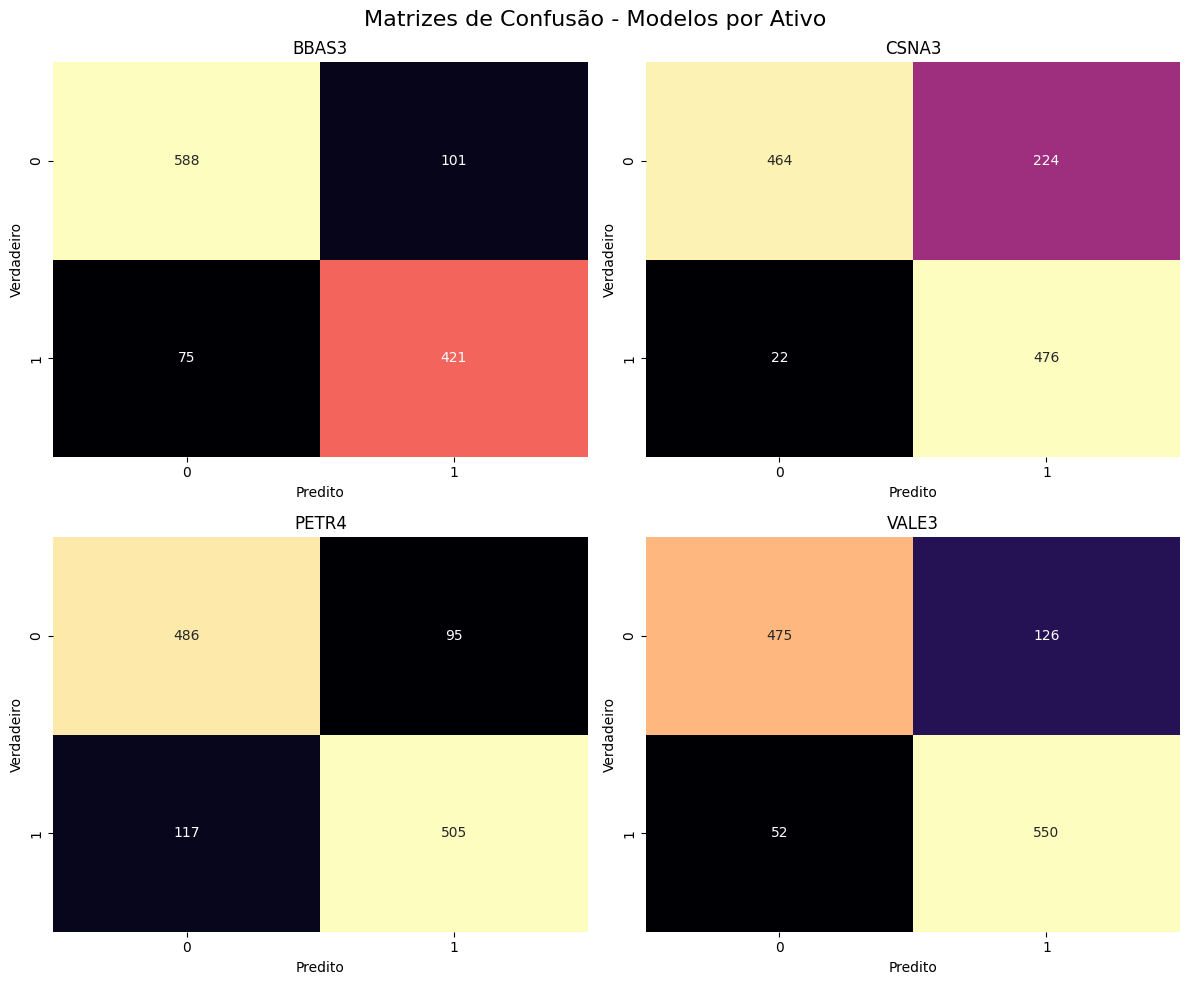

In [ ]:
resultados = {
    "BBAS3": (y_test_bbas3, y_pred_bbas3),
    "CSNA3": (y_test_csna3, y_pred_csna3),
    "PETR4": (y_test_petr4, y_pred_petr4),
    "VALE3": (y_test_vale3, y_pred_vale3)
}

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Matrizes de Confusão - Modelos por Ativo', fontsize=16)

axs = axs.flatten()

for i, (nome, (y_true, y_pred)) in enumerate(resultados.items()):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="magma", cbar=False, ax=axs[i])
    axs[i].set_title(f'{nome}')
    axs[i].set_xlabel('Predito')
    axs[i].set_ylabel('Verdadeiro')

plt.tight_layout()
plt.show()

## Backtest por Ativo

Realizamos um backtest individual para cada ativo, simulando o crescimento do capital ao seguir as previsões do modelo em comparação com a estratégia tradicional **Buy & Hold**.

Para cada ativo:
- Calculamos o retorno percentual diário com base no preço de fechamento
- Simulamos o capital acumulado da estratégia baseada no modelo (comprar ou vender conforme a previsão)
- Comparamos o desempenho com a estratégia Buy & Hold, que consiste em simplesmente manter o ativo ao longo do período
- Calculamos o Max Drawdown, que representa a maior perda acumulada em relação ao pico de capital, indicando o risco máximo de queda
- Calculamos o Sharpe Ratio, que mede o retorno da estratégia ajustado ao risco (volatilidade), indicando a eficiência da estratégia — quanto maior o Sharpe Ratio, melhor a relação entre retorno e risco

O gráfico ilustra a evolução do capital para as duas estratégias, permitindo avaliar se o modelo de Deep Learning é capaz de gerar maior retorno financeiro em relação à abordagem passiva.

In [ ]:
def calcular_drawdown(capital):
    rolling_max = capital.cummax()
    drawdown = (capital - rolling_max) / rolling_max
    max_drawdown = drawdown.min() * 100
    return max_drawdown

def calcular_sharpe(retornos, risco_zero=0.0):
    retorno_medio = retornos.mean()
    volatilidade = retornos.std()
    if volatilidade == 0:
        return np.nan
    sharpe = (retorno_medio - risco_zero) / volatilidade
    sharpe_annualizado = sharpe * np.sqrt(252)
    return sharpe_annualizado

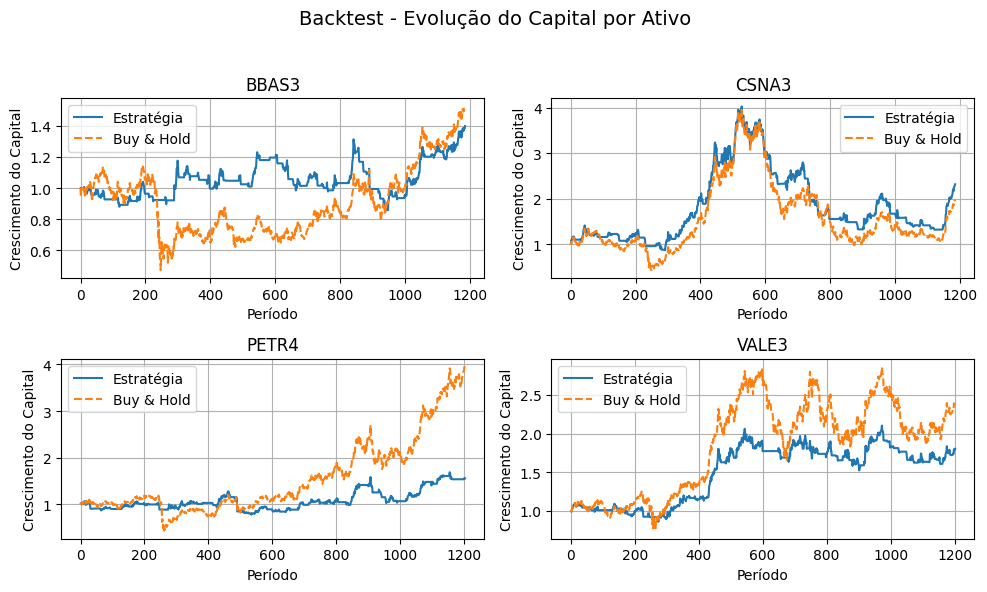



       Retorno_Estrategia (%)  Retorno_Buy_Hold (%)  Max Drawdown (%)  \
BBAS3               39.650463             52.228217        -34.620611   
CSNA3              131.786133             98.226663        -67.109654   
PETR4               55.969152            293.327578        -39.069439   
VALE3               79.975766            139.777075        -26.171939   

       Sharpe Ratio  
BBAS3      0.461287  
CSNA3      0.653082  
PETR4      0.478121  
VALE3      0.640587  


In [ ]:
ativos = {
    "BBAS3": {"df": df_teste_bbas3, "y_pred": y_pred_bbas3.flatten()},
    "CSNA3": {"df": df_teste_csna3, "y_pred": y_pred_csna3.flatten()},
    "PETR4": {"df": df_teste_petr4, "y_pred": y_pred_petr4.flatten()},
    "VALE3": {"df": df_teste_vale3, "y_pred": y_pred_vale3.flatten()}
}

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

fig.suptitle("Backtest - Evolução do Capital por Ativo", fontsize=14)

resultados = {}

axes = axes.flatten()

for i, (ticker, dados) in enumerate(ativos.items()):
    df = dados['df'].copy()
    y_pred = dados['y_pred']

    df['Predito'] = y_pred
    df['Retorno'] = df['Close'].pct_change().fillna(0)
    df['Posicao'] = df['Predito']
    df['Retorno_Estrategia'] = df['Posicao'].shift(1) * df['Retorno']
    df['Capital_Estrategia'] = (1 + df['Retorno_Estrategia']).cumprod()
    df['Capital_Buy_Hold'] = (1 + df['Retorno']).cumprod()

    retorno_estrategia = (df['Capital_Estrategia'].iloc[-1] - 1) * 100
    retorno_buyhold = (df['Capital_Buy_Hold'].iloc[-1] - 1) * 100

    max_drawdown = calcular_drawdown(df['Capital_Estrategia'])
    sharpe_ratio = calcular_sharpe(df['Retorno_Estrategia'])

    resultados[ticker] = {
        "Retorno_Estrategia (%)": retorno_estrategia,
        "Retorno_Buy_Hold (%)": retorno_buyhold,
        "Max Drawdown (%)": max_drawdown,
        "Sharpe Ratio": sharpe_ratio
    }

    ax = axes[i]
    ax.plot(df['Capital_Estrategia'], label='Estratégia')
    ax.plot(df['Capital_Buy_Hold'], '--', label='Buy & Hold')
    ax.set_title(f"{ticker}")
    ax.set_xlabel("Período")
    ax.set_ylabel("Crescimento do Capital")
    ax.grid()
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print('\n')
df_resultados = pd.DataFrame(resultados).T
print(df_resultados)

Esse conjunto de gráficos e métricas mostra que, no cenário atual, a estratégia baseada no modelo de Deep Learning não superou o desempenho do Buy & Hold em termos de retorno acumulado para a maioria dos ativos, com exceção de CSNA3, onde a estratégia obteve maior crescimento do capital

Por outro lado:

- O modelo conseguiu reduzir o Drawdown Máximo (queda máxima do capital) em todos os ativos, indicando um comportamento mais conservador e menos arriscado, o que pode ser desejável dependendo do perfil do investidor

- O Sharpe Ratio, que mede o retorno ajustado ao risco, ainda está relativamente baixo em todos os casos, o que demonstra que o modelo precisa de ajustes para tornar a relação risco/retorno mais competitiva

Em resumo, a estratégia do modelo demonstrou boa capacidade de reduzir perdas extremas, mas ainda sacrifica o potencial de retorno em cenários de alta prolongada, comportamento típico de modelos trend followers conservadores. Isso reforça que o trabalho está bem estruturado, mas abre espaço para melhorias no refinamento do modelo ou nos critérios de decisão

# O que mais poderia ser feito?

## Trend Follower Unificado

Neste modelo concatenamos todos os datasets em um, com o objetivo de criar um modelo unificado, adicionamos a feature Ticker identificando a qual ativo a amostra se refere, utilizamos one-hot-encoder para identificação através de novas features e posteriomente efetuar a normalização<br>

Testar um modelo trend follower unificado é interessante porque permite identificar padrões de tendência em diferentes ativos utilizando uma arquitetura única, capaz de aprender comportamentos gerais de mercado<br>

Esse tipo de abordagem busca capturar movimentos de alta e baixa com o objetivo de seguir as tendências predominantes, aumentando o potencial de retorno ao evitar operações contra o fluxo do mercado. Além disso, ao treinar o modelo de forma unificada em ativos distintos, é possível avaliar a capacidade de generalização do algoritmo, reduzindo o risco de overfitting e ampliando sua aplicação prática em cenários reais

In [ ]:
df_treino_bbas3['Ticker'] = 'BBAS3'
df_teste_bbas3['Ticker'] = 'BBAS3'

df_treino_csna3['Ticker'] = 'CSNA3'
df_teste_csna3['Ticker'] = 'CSNA3'

df_treino_petr4['Ticker'] = 'PETR4'
df_teste_petr4['Ticker'] = 'PETR4'

df_treino_vale3['Ticker'] = 'VALE3'
df_teste_vale3['Ticker'] = 'VALE3'

df_treino_final = pd.concat([df_treino_bbas3, df_treino_csna3, df_treino_petr4, df_treino_vale3],ignore_index=True)

df_teste_final = pd.concat([df_teste_bbas3, df_teste_csna3, df_teste_petr4, df_teste_vale3], ignore_index=True)

df_treino_final = pd.get_dummies(df_treino_final, columns=['Ticker'])
df_teste_final = pd.get_dummies(df_teste_final, columns=['Ticker'])

features = [
    'Past_1_Days_Close',
    'Past_2_Days_Close',
    'Past_3_Days_Close',
    'Past_4_Days_Close',
    'Past_5_Days_Close',
    'Past_6_Days_Close',
    'Past_7_Days_Close',
    'Past_8_Days_Close',
    'Past_9_Days_Close',
    'Past_10_Days_Close',
    'Past_11_Days_Close',
    'Past_12_Days_Close',
    'Past_13_Days_Close',
    'Past_14_Days_Close',
    'Past_15_Days_Close',
    'Ticker_BBAS3',
    'Ticker_CSNA3',
    'Ticker_PETR4',
    'Ticker_VALE3'
            ]

target = ['Label']

X_train_final = df_treino_final[features].to_numpy()
y_train_final = df_treino_final[target].to_numpy()

X_test_final = df_teste_final[features].to_numpy()
y_test_final = df_teste_final[target].to_numpy()

scaler.fit(X_train_final)
X_train_final = scaler.transform(X_train_final).reshape(-1,19,1)
X_test_final = scaler.transform(X_test_final).reshape(-1,19,1)

model = Sequential()
model.add(Conv1D(128, 3, activation='relu', input_shape=(19,1), padding='same'))
model.add(BatchNormalization())
model.add(Conv1D(128, 3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.3))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

optimizer = Adam(learning_rate=0.0003)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_final,
                    y_train_final,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - accuracy: 0.5457 - loss: 0.6888 - val_accuracy: 0.5957 - val_loss: 0.6748
Epoch 2/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.5738 - loss: 0.6716 - val_accuracy: 0.5389 - val_loss: 0.6524
Epoch 3/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.6824 - loss: 0.5780 - val_accuracy: 0.5758 - val_loss: 0.6411
Epoch 4/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.7285 - loss: 0.5176 - val_accuracy: 0.5590 - val_loss: 0.7263
Epoch 5/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.7551 - loss: 0.4774 - val_accuracy: 0.7950 - val_loss: 0.4694
Epoch 6/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.7742 - loss: 0.4589 - val_accuracy: 0.8248 - val_loss: 0.3645
Epoch 7/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.7795 - loss: 0.4453 - val_accuracy: 0.8209 - val_loss: 0.3842
Epoch 8/100
478/478 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.7800 - loss: 0

### Evolução da Acurácia

Observa-se uma tendência de melhora contínua na acurácia dos dados de treino, enquanto a acurácia da validação apresenta oscilações, com alguns picos e quedas, comportamento esperado em problemas financeiros devido à alta variabilidade do mercado.

Apesar das oscilações, o modelo conseguiu atingir acurácia de validação em torno de 82% a 85% nas melhores épocas, indicando que o treinamento foi efetivo e que o EarlyStopping provavelmente evitou o overfitting nas últimas iterações. A distância entre as curvas é relativamente pequena, o que sugere que o modelo generaliza de maneira razoável.

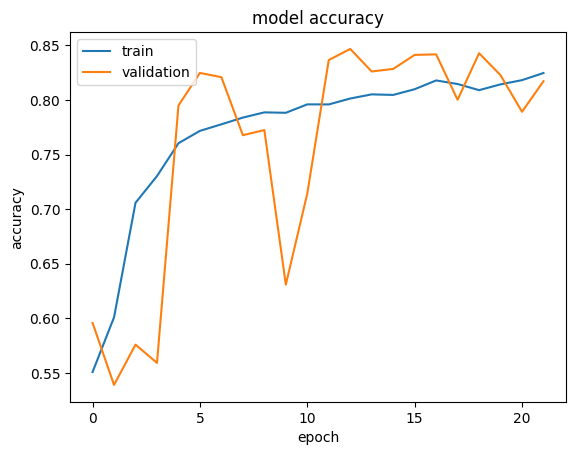

In [ ]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Erro e Acurácia

Esse resultado mostra que o modelo final, aplicado sobre o dataset unificado, obteve uma acurácia de 74,36%, o que representa um desempenho razoável para um cenário financeiro, onde prever direções de mercado é desafiador. O erro do modelo ficou em 25,64%, ou seja, aproximadamente 1 em cada 4 previsões está incorreta.

Essa performance é inferior ao observado nos testes individuais por ativo, o que é esperado em modelos unificados, pois o desafio de capturar padrões gerais para diferentes ativos ao mesmo tempo aumenta a complexidade do problema. Mesmo assim, o resultado demonstra que o modelo consegue capturar tendências de forma consistente, ainda que haja margem para otimizações futuras.

In [ ]:
scores = model.evaluate(X_test_final, y_test_final, verbose=0)
print("Erro da CNN: %.2f%%" % (100-scores[1]*100))
print("Acurária da CNN: %.2f%%" % (scores[1]*100))

Erro da CNN: 25.64%
Acurária da CNN: 74.36%


### Precision e Recall

O relatório de classificação mostra que o modelo possui um comportamento assimétrico no dataset unificado:<br>

- Para a classe 1 (tendência de alta), o modelo tem bom recall (88%), ou seja, ele consegue identificar corretamente a maioria dos cenários de alta, o que é útil para estratégias de compra. Porém, a precisão é menor (67%), indicando que há falsos positivos, ou seja, o modelo às vezes prevê alta quando o mercado não sobe<br>

- Para a classe 0 (tendência de queda), ocorre o inverso: alta precisão (86%) e baixo recall (62%), o que significa que quando o modelo prevê queda geralmente acerta, mas ele não consegue identificar todas as quedas reais<br>

- A acurácia geral é de 74%, coerente com o desempenho do backtest<br>

Esse perfil indica que o modelo é mais sensível a identificar oportunidades de alta (bom recall da classe 1) e tende a ser conservador ao prever quedas, o que pode ser positivo ou negativo dependendo da estratégia e perfil de risco adotado

In [ ]:
y_pred_final = (model.predict(X_test_final) > 0.5).astype(int).flatten()

print(classification_report(y_test_final, y_pred_final, zero_division=0))

150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
              precision    recall  f1-score   support

           0       0.86      0.62      0.72      2559
           1       0.67      0.88      0.76      2218

    accuracy                           0.74      4777
   macro avg       0.76      0.75      0.74      4777
weighted avg       0.77      0.74      0.74      4777



### Matriz de Confusão

O modelo acerta bem as previsões de alta (classe 1), com 1957 acertos e apenas 261 erros (falsos negativos)<br>

Já nas previsões de queda (classe 0), o modelo apresenta 964 falsos positivos, ou seja, muitas vezes prevê alta quando o mercado não sobe, o que reduz a precisão da classe 0<br>

Esse comportamento reforça que o modelo tem maior sensibilidade para capturar oportunidades de alta, mas menor capacidade de identificar corretamente os cenários de queda<br>

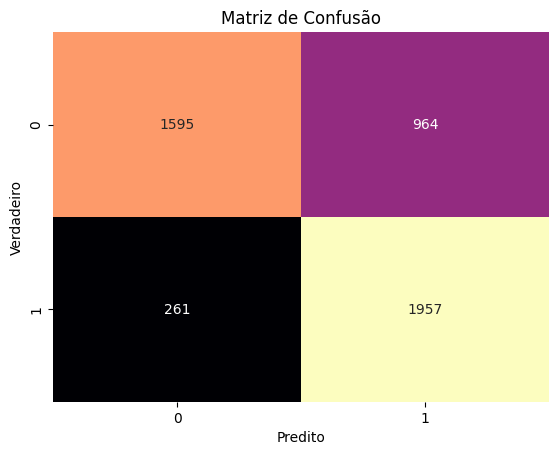

In [ ]:
sns.heatmap(confusion_matrix(y_test_final, y_pred_final), annot=True, fmt='d', cmap="magma", cbar=False)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

### Backtest Trend Follower Unificado

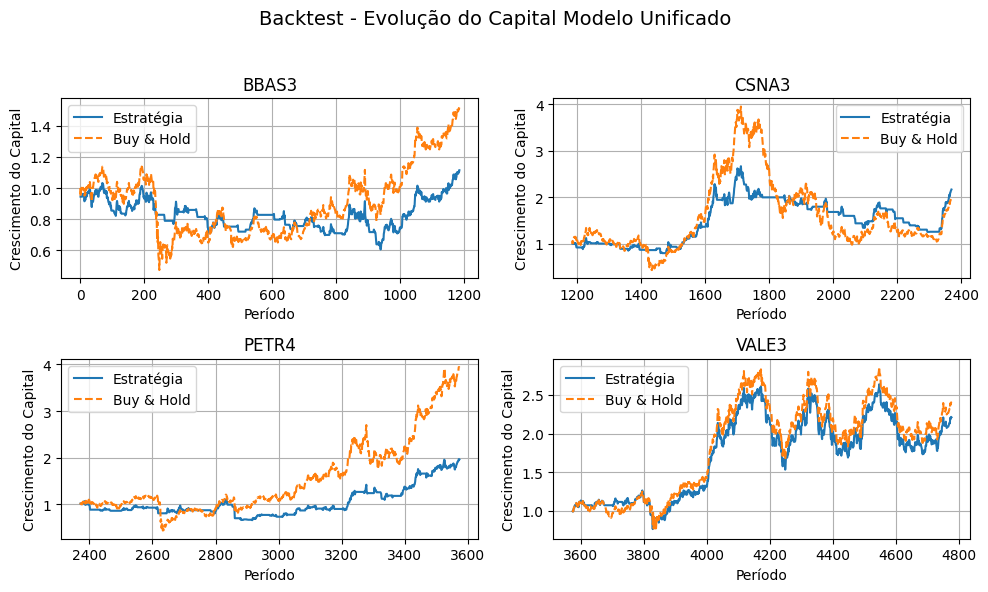



       Retorno_Estrategia (%)  Retorno_Buy_Hold (%)  Max Drawdown (%)  \
BBAS3               11.389247             52.228217        -41.291564   
CSNA3              116.634141             98.226663        -52.917672   
PETR4               96.380674            293.327578        -39.952151   
VALE3              121.033308            139.777075        -41.343004   

       Sharpe Ratio  
BBAS3      0.215608  
CSNA3      0.677039  
PETR4      0.669044  
VALE3      0.656601  


In [ ]:
df_bt = df_teste_final.copy()

df_bt['y_pred'] = y_pred_final

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle("Backtest - Evolução do Capital Modelo Unificado", fontsize=14)

resultados = {}
axes = axes.flatten()

for i, ticker in enumerate(['BBAS3', 'CSNA3', 'PETR4', 'VALE3']):

    df = df_bt[df_bt['Ticker_' + ticker] == 1].copy()
    y_pred = df['y_pred'].values.flatten()

    df['Predito'] = y_pred
    df['Retorno'] = df['Close'].pct_change().fillna(0)
    df['Posicao'] = df['Predito']
    df['Retorno_Estrategia'] = df['Posicao'].shift(1) * df['Retorno']
    df['Capital_Estrategia'] = (1 + df['Retorno_Estrategia']).cumprod()
    df['Capital_Buy_Hold'] = (1 + df['Retorno']).cumprod()

    retorno_estrategia = (df['Capital_Estrategia'].iloc[-1] - 1) * 100
    retorno_buyhold = (df['Capital_Buy_Hold'].iloc[-1] - 1) * 100

    max_drawdown = calcular_drawdown(df['Capital_Estrategia'])
    sharpe_ratio = calcular_sharpe(df['Retorno_Estrategia'])

    resultados[ticker] = {
        "Retorno_Estrategia (%)": retorno_estrategia,
        "Retorno_Buy_Hold (%)": retorno_buyhold,
        "Max Drawdown (%)": max_drawdown,
        "Sharpe Ratio": sharpe_ratio
    }

    ax = axes[i]
    ax.plot(df['Capital_Estrategia'], label='Estratégia')
    ax.plot(df['Capital_Buy_Hold'], '--', label='Buy & Hold')
    ax.set_title(f"{ticker}")
    ax.set_xlabel("Período")
    ax.set_ylabel("Crescimento do Capital")
    ax.grid()
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print('\n')
df_resultados = pd.DataFrame(resultados).T
print(df_resultados)


- BBAS3 e PETR4: O modelo não superou o Buy & Hold, apresentando retorno inferior e maior Drawdown, o que indica maior risco e menor desempenho em relação à estratégia passiva<br>

- CSNA3 e VALE3: A estratégia chegou a se aproximar ou superar o Buy & Hold em alguns períodos, mas ainda assim o retorno total e o Sharpe Ratio mostram que o modelo não foi consistentemente superior<br>

## CNN2D + GAF + TSFresh

Neste experimento combinamos duas técnicas muito utilizadas em competições de alto nível do Kaggle, principalmente em desafios relacionados a séries temporais, financeiros, detecção de anomalias e previsão de sensores<br><br>

A combinação de CNN 2D, GAF e TSFresh é uma abordagem híbrida avançada que explora diferentes representações dos dados para potencializar o desempenho do modelo em séries temporais financeiras<br><br>

- GAF (Gramian Angular Fields): converte séries temporais em imagens 2D, preservando as relações temporais e destacando padrões de correlação e estrutura global dos dados. Essa transformação facilita a aplicação de técnicas de visão computacional ao problema financeiro<br><br>

- CNN 2D (Redes Convolucionais 2D): após a conversão em imagens, as CNNs extraem automaticamente características visuais e espaciais relevantes dos GAFs, capturando padrões que seriam difíceis de perceber em dados brutos ou unidimensionais, como ciclos ou mudanças abruptas de comportamento<br><br>

- TSFresh (Time Series Feature Extraction): gera um conjunto estatístico robusto de características tradicionais das séries temporais (métricas de tendência, entropia, autocorrelação, etc.), oferecendo uma representação complementar e tabular, enriquecendo a entrada do modelo com informações que os GAFs podem não capturar diretamente

### Definição de Features e Normalização

In [ ]:
features_preco = [f'Past_{i}_Days_Close' for i in range(1, 16)]
features_ticker = ['Ticker_BBAS3', 'Ticker_CSNA3', 'Ticker_PETR4', 'Ticker_VALE3']
target = 'Label'

scaler_precos = StandardScaler()
X_treino_precos = scaler_precos.fit_transform(df_treino_final[features_preco])
X_teste_precos = scaler_precos.transform(df_teste_final[features_preco])

### Geração das Imagens GAF

Geração das imagens e exemplo visual clássico do GAF, usado para transformar séries temporais em imagens bidimensionais interpretáveis por redes neurais convolucionais<br><br>

- Cada pixel da matriz representa a relação angular entre dois pontos da série temporal

- O eixo X e Y correspondem ao tempo, ou seja, cada ponto da série é comparado com todos os outros pontos

- As cores indicam o nível de correlação angular entre esses pontos, variando de -1 a +1, conforme mostrado na barra lateral

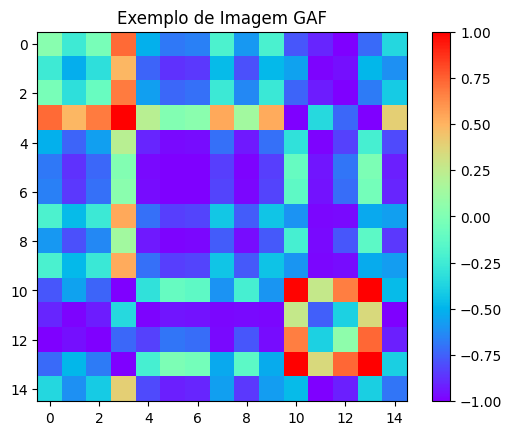

In [ ]:
gaf = GramianAngularField(method='summation')

X_train_gaf = np.array([gaf.fit_transform(seq.reshape(1, -1))[0] for seq in X_treino_precos]).reshape(-1, 15, 15, 1)
X_test_gaf = np.array([gaf.fit_transform(seq.reshape(1, -1))[0] for seq in X_teste_precos]).reshape(-1, 15, 15, 1)

plt.imshow(X_train_gaf[0, :, :, 0], cmap='rainbow')
plt.title('Exemplo de Imagem GAF')
plt.colorbar()
plt.show()

### Extração de Features com TSFresh

Esse código prepara os dados no formato exigido pela biblioteca TSFresh para extração automática de características de séries temporais<br>

Ele transforma o dataset de treino e teste de formato wide para long, onde cada linha representa um valor da série ao longo do tempo associada a um identificador único<br>

Em seguida, utiliza o TSFresh para extrair um conjunto robusto de features estatísticas e de comportamento temporal com base nesses dados<br>

Por fim, aplica um processo de imputação para lidar com valores ausentes nas features extraídas, deixando os dados prontos para serem usados em modelos

In [ ]:
df_long_train = []
for idx, row in df_treino_final.iterrows():
    for dia in range(15):
        df_long_train.append({
            'id': idx,
            'time': dia,
            'value': row[features_preco[dia]]
        })
df_long_train = pd.DataFrame(df_long_train)

features_extracted_train = extract_features(df_long_train, column_id='id', column_sort='time')
features_extracted_train = impute(features_extracted_train)

df_long_test = []
for idx, row in df_teste_final.iterrows():
    for dia in range(15):
        df_long_test.append({
            'id': idx,
            'time': dia,
            'value': row[features_preco[dia]]
        })
df_long_test = pd.DataFrame(df_long_test)

features_extracted_test = extract_features(df_long_test, column_id='id', column_sort='time')
features_extracted_test = impute(features_extracted_test)

Feature Extraction: 100%|██████████| 19094/19094 [38:01<00:00,  8.37it/s]
/usr/local/lib/python3.11/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['value__partial_autocorrelation__lag_7'
 'value__partial_autocorrelation__lag_8'
 'value__partial_autocorrelation__lag_9'
 'value__spkt_welch_density__coeff_8'
 'value__ar_coefficient__coeff_0__k_10'
 'value__ar_coefficient__coeff_1__k_10'
 'value__ar_coefficient__coeff_2__k_10'
 'value__ar_coefficient__coeff_3__k_10'
 'value__ar_coefficient__coeff_4__k_10'
 'value__ar_coefficient__coeff_5__k_10'
 'value__ar_coefficient__coeff_6__k_10'
 'value__ar_coefficient__coeff_7__k_10'
 'value__ar_coefficient__coeff_8__k_10'
 'value__ar_coefficient__coeff_9__k_10'
 'value__fft_coefficient__attr_"real"__coeff_8'
 'value__fft_coefficient__attr_"real"__coeff_9'
 'value__fft_coefficient__attr_"real"__coeff_10'
 'value__fft_coefficient__attr_"real"__coeff_11'
 'value__fft_coefficient__attr_"real"__coeff_12'
 'value_

In [ ]:
features_extracted_train.shape

(19094, 783)

In [ ]:
features_extracted_test.shape

(4777, 783)

### Implementação e Treino da CNN2D + GAF + TSFresh

Esse trecho implementa um modelo híbrido de Deep Learning utilizando a API Functional do Tensorflow, essa arquitetura combina imagens geradas por GAF com features estatísticas extraídas via TSFresh, integrando ambas as fontes de informação em um único pipeline de classificação binária<br><br>

Inicialmente, as features do TSFresh passam por uma normalização com StandardScaler, enquanto os targets para treino e teste são extraídos<br><br>

Em seguida, são definidas duas entradas independentes: uma para as imagens GAF, processadas por uma arquitetura CNN 2D composta por camadas convolucionais, normalização em lote, pooling e dropout; e outra entrada para os dados tabulares do TSFresh, processada por uma rede densa tradicional (MLP)<br><br>

Após extração dos padrões de ambas as fontes, os vetores resultantes são concatenados e passam por camadas densas adicionais antes da camada de saída final com ativação sigmoid, apropriada para problemas de classificação binária<br><br>

O modelo é compilado com otimizador Adam e função de perda binária, e utiliza EarlyStopping para interromper o treino se não houver melhora no conjunto de validação, prevenindo overfitting

In [ ]:
scaler_tsf = StandardScaler()
X_train_tsfresh = scaler_tsf.fit_transform(features_extracted_train)
X_test_tsfresh = scaler_tsf.transform(features_extracted_test)

y_train = df_treino_final[target].values
y_test = df_teste_final[target].values

input_gaf = Input(shape=(15, 15, 1), name='input_gaf')
input_tsfresh = Input(shape=(X_train_tsfresh.shape[1],), name='input_tsfresh')

x = Conv2D(32, (3,3), activation='relu', padding='same')(input_gaf)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.3)(x)

x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.3)(x)

x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.4)(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)

y_branch = Dense(128, activation='relu')(input_tsfresh)
y_branch = Dropout(0.3)(y_branch)
y_branch = Dense(64, activation='relu')(y_branch)

combined = concatenate([x, y_branch])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(1, activation='sigmoid')(z)

model_hibrido = Model(inputs=[input_gaf, input_tsfresh], outputs=output)

optimizer = Adam(learning_rate=0.0003)
model_hibrido.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_hibrido.fit(
    [X_train_gaf, X_train_tsfresh], y_train,
    validation_data=([X_test_gaf, X_test_tsfresh], y_test),
    epochs=100, batch_size=32, callbacks=[early_stop], verbose=1
)

Epoch 1/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.7585 - loss: 0.5050 - val_accuracy: 0.8700 - val_loss: 0.3468
Epoch 2/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - accuracy: 0.8793 - loss: 0.2723 - val_accuracy: 0.8612 - val_loss: 0.3299
Epoch 3/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.8836 - loss: 0.2609 - val_accuracy: 0.8658 - val_loss: 0.3453
Epoch 4/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.8915 - loss: 0.2470 - val_accuracy: 0.8708 - val_loss: 0.3831
Epoch 5/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.8989 - loss: 0.2355 - val_accuracy: 0.8725 - val_loss: 0.3823
Epoch 6/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.8975 - loss: 0.2311 - val_accuracy: 0.8748 - val_loss: 0.3258
Epoch 7/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.9017 - loss: 0.2255 - val_accuracy: 0.8807 - val_loss: 0.3611
Epoch 8/100
597/597 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.9058 - loss: 0

### Visualização da Arquitetura de Camadas

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


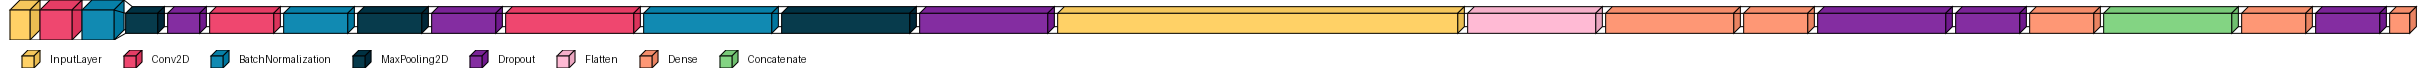

In [ ]:
visualkeras.layered_view(model_hibrido, scale_xy=2.0, scale_z=1.0, legend=True)

### Precision e Recall

Acurácia geral: 87%, o que significa que o modelo acerta 87% das previsões totais<br><br>

- Classe 0:
 - Precisão: 93% (baixa quantidade de falsos positivos)
 - Recall: 83% (algumas oportunidades reais de venda não são capturadas)<br><br>

- Classe 1:
 - Precisão: 83% (quantidade moderada de falsos positivos)
 - Recall: 93% (alta taxa de acerto nas oportunidades de compra)<br><br>

Esse comportamento indica que o modelo é mais conservador ao sinalizar vendas (prioriza minimizar falsos alarmes de venda), enquanto é mais agressivo em identificar oportunidades de compra, com alta taxa de acerto<br><br>

No contexto financeiro, esse equilíbrio entre precisão e recall pode ser interessante dependendo da estratégia. No entanto, a efetividade final deve ser sempre validada com backtests, pois métricas isoladas não garantem lucro consistente no mercado real

In [ ]:
y_pred = (model_hibrido.predict([X_test_gaf, X_test_tsfresh]) > 0.5).astype(int).flatten()

print(classification_report(y_test, y_pred, zero_division=0))

150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      2559
           1       0.83      0.93      0.87      2218

    accuracy                           0.87      4777
   macro avg       0.88      0.88      0.87      4777
weighted avg       0.88      0.87      0.87      4777



### Matriz de Confusão

- Verdadeiro Negativo (Classe 0 prevista corretamente): 2126
- Falso Positivo (Classe 0 previsto como 1): 433
- Falso Negativo (Classe 1 previsto como 0): 165
- Verdadeiro Positivo (Classe 1 prevista corretamente): 2053

Resumo:

- O modelo apresenta bom equilíbrio, com alta quantidade de acertos tanto para a classe 0 quanto para a classe 1

- Ainda existem falsos positivos e falsos negativos, mas os erros são relativamente baixos, o que reforça os bons resultados de acurácia (87%) e f1-score (0.87) que você mostrou anteriormente

Esse comportamento indica que o modelo consegue capturar padrões relevantes de tendência com GAF + TSFresh, sendo robusto para previsões binárias de séries temporais

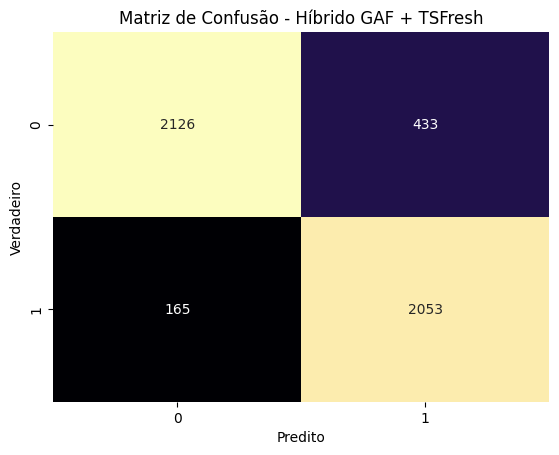

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', cbar=False)
plt.title('Matriz de Confusão - Híbrido GAF + TSFresh')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

### Evolução da Acurácia

- A acurácia de treino sobe consistentemente, o que é esperado

- A acurácia de validação atinge um platô por volta da 7ª época e depois apresenta leve queda, o que sugere sinais de overfitting (o modelo começa a se ajustar muito ao treino, perdendo generalização)

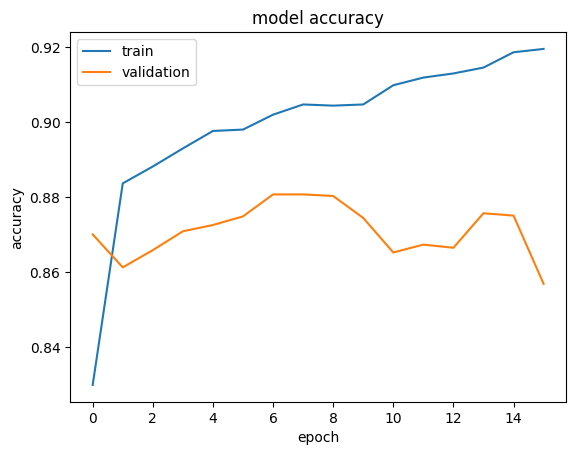

In [ ]:
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Erro e Acurácia

Esse desempenho indica que o modelo consegue generalizar relativamente bem os padrões de tendência nas séries temporais, aproveitando tanto informações de imagem (GAF) quanto de estatísticas temporais (TSFresh), superando os resultados obtidos com modelos simples anteriormente

In [ ]:
scores = model_hibrido.evaluate([X_test_gaf, X_test_tsfresh], y_test, verbose=0)

print("Erro do Modelo Híbrido: %.2f%%" % (100 - scores[1] * 100))
print("Acurácia do Modelo Híbrido: %.2f%%" % (scores[1] * 100))

Erro do Modelo Híbrido: 12.52%
Acurácia do Modelo Híbrido: 87.48%


### Backtest CNN2D + GAF + TSFresh

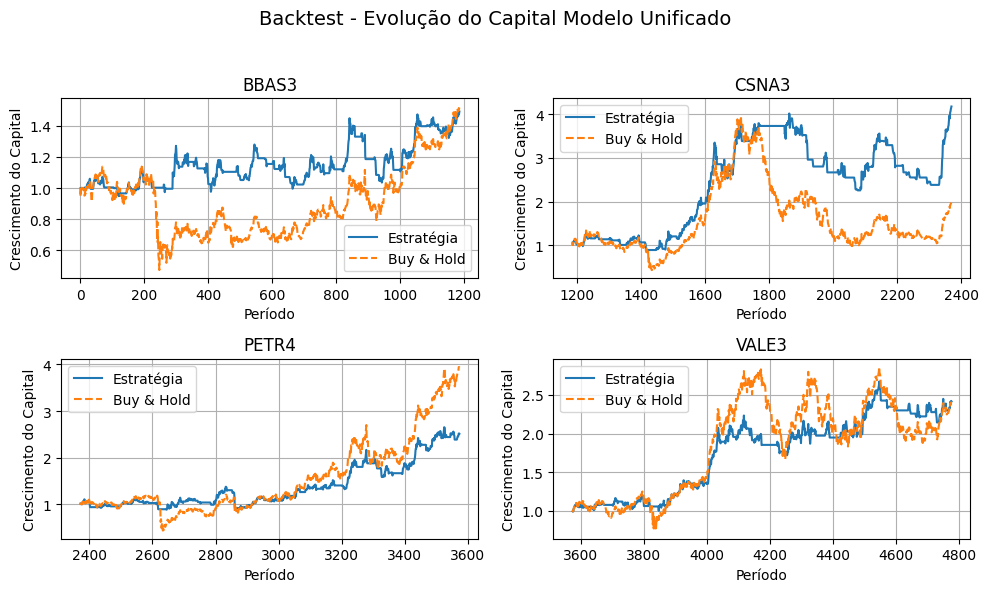



       Retorno_Estrategia (%)  Retorno_Buy_Hold (%)  Max Drawdown (%)  \
BBAS3               49.009595             52.228217        -28.482885   
CSNA3              317.141490             98.226663        -43.770724   
PETR4              151.339315            293.327578        -34.311502   
VALE3              141.706858            139.777075        -23.059862   

       Sharpe Ratio  
BBAS3      0.514232  
CSNA3      1.020281  
PETR4      0.829418  
VALE3      0.896179  


In [ ]:
df_bt = df_teste_final.copy()

df_bt['y_pred'] = y_pred

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle("Backtest - Evolução do Capital Modelo Unificado", fontsize=14)

resultados = {}
axes = axes.flatten()

for i, ticker in enumerate(['BBAS3', 'CSNA3', 'PETR4', 'VALE3']):

    df = df_bt[df_bt['Ticker_' + ticker] == 1].copy()
    y_pred = df['y_pred'].values.flatten()

    df['Predito'] = y_pred
    df['Retorno'] = df['Close'].pct_change().fillna(0)
    df['Posicao'] = df['Predito']
    df['Retorno_Estrategia'] = df['Posicao'].shift(1) * df['Retorno']
    df['Capital_Estrategia'] = (1 + df['Retorno_Estrategia']).cumprod()
    df['Capital_Buy_Hold'] = (1 + df['Retorno']).cumprod()

    retorno_estrategia = (df['Capital_Estrategia'].iloc[-1] - 1) * 100
    retorno_buyhold = (df['Capital_Buy_Hold'].iloc[-1] - 1) * 100

    max_drawdown = calcular_drawdown(df['Capital_Estrategia'])
    sharpe_ratio = calcular_sharpe(df['Retorno_Estrategia'])

    resultados[ticker] = {
        "Retorno_Estrategia (%)": retorno_estrategia,
        "Retorno_Buy_Hold (%)": retorno_buyhold,
        "Max Drawdown (%)": max_drawdown,
        "Sharpe Ratio": sharpe_ratio
    }

    ax = axes[i]
    ax.plot(df['Capital_Estrategia'], label='Estratégia')
    ax.plot(df['Capital_Buy_Hold'], '--', label='Buy & Hold')
    ax.set_title(f"{ticker}")
    ax.set_xlabel("Período")
    ax.set_ylabel("Crescimento do Capital")
    ax.grid()
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print('\n')
df_resultados = pd.DataFrame(resultados).T
print(df_resultados)

O modelo superou o Buy & Hold em CSNA3 e PETR4, apresentando retornos expressivos<br>

- Em BBAS3 e VALE3, os resultados da estratégia ficaram próximos ou ligeiramente abaixo do Buy & Hold, mas ainda com Sharpe Ratio positivo<br>

- O Sharpe Ratio superior a 1 em CSNA3 sugere boa relação risco-retorno nesse ativo<br>

- O Max Drawdown permanece controlado, abaixo de -44% em todos os ativos<br>

- O gráfico revela que o modelo conseguiu capturar tendências e proteger o capital em momentos de queda, mostrando que a estratégia é funcional, mas com potencial de ajustes para ativos específicos

Conclui-se que o desenvolvimento do modelo híbrido, combinando redes convolucionais 2D aplicadas sobre imagens GAF com variáveis extraídas por TSFresh, demonstrou resultados satisfatórios na tarefa de previsão de tendências em séries temporais financeiras<br>

Os testes indicaram que o modelo foi capaz de capturar padrões relevantes dos dados históricos, com destaque para a performance do ativo PETR4, onde a estratégia baseada no modelo superou o retorno obtido pela estratégia tradicional de Buy & Hold. Além disso, observou-se redução no drawdown e melhoria do Sharpe Ratio em alguns ativos, o que aponta maior estabilidade e melhor relação risco-retorno quando comparado à abordagem passiva<br>

Apesar disso, algumas limitações ainda são observadas, como a diferença de desempenho entre treino e validação, além de resultados que variam de acordo com a característica específica de cada ativo. Tais pontos reforçam a necessidade de ajustes adicionais, otimizações nos hiperparâmetros e possíveis aprimoramentos no pipeline de pré-processamento e engenharia de atributos<br>